In [1]:
import pandas as pd
import os
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
import matplotlib.pyplot as plt
import pydeseq2 as deseq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.preprocessing import deseq2_norm

from custom_functions import *

save_format = "svg"

# Load data

## Bulk gastruloid
For this analysis, we will only retain the samples from the 72h and the initial condition at 48h, immediately before Chiron treatment.

In [2]:
#Counts
df_gastruloid = pd.read_csv("data/chir_act_counts.csv",index_col=0).T
df_gastruloid = df_gastruloid.loc[:,~df_gastruloid.columns.duplicated()].copy() #Remove potentially duplicated genes names (very few and irrelevant genes are duplicated)

In [3]:
#Metadata
df_gastruloid_metadata = pd.read_csv("data/metadata_chir_new.csv",index_col=0)

In [4]:
# Marker genes
marker_genes = pd.read_csv("marker_genes.csv",header=None).values[:,0]

# Preprocessing and QC

**DATASET EXPLORATION**

In [5]:
print(f"Samples in dataset: {df_gastruloid.shape[0]}")
print(f"Genes in dataset: {df_gastruloid.shape[1]}")

Samples in dataset: 66
Genes in dataset: 55367


**LIBRARY SIZES**

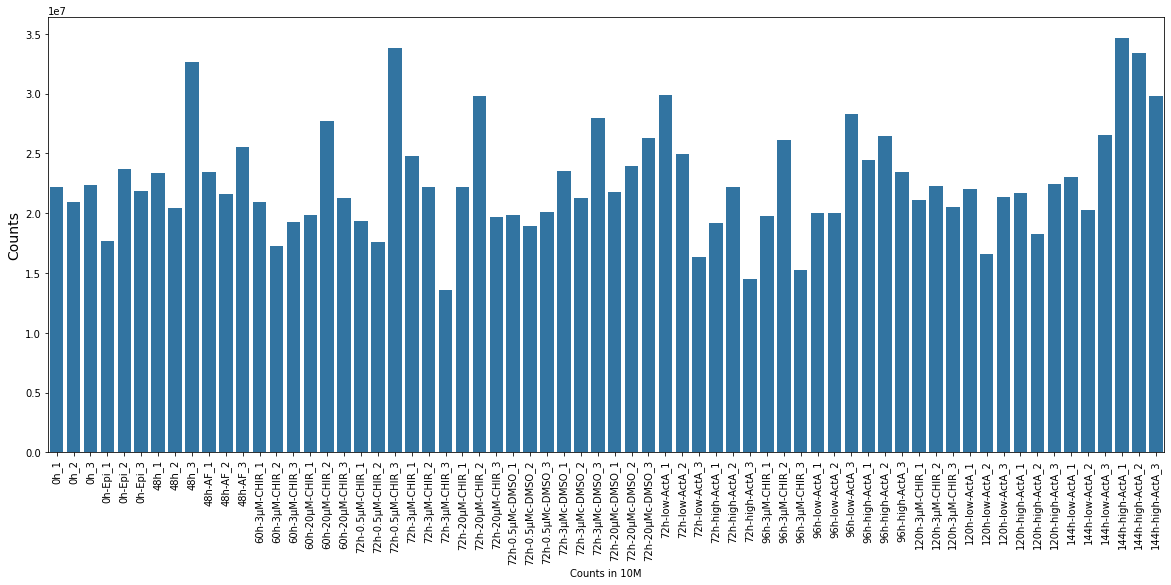

In [6]:
fig,ax=plt.subplots(1,1,figsize=(20,8))
sns.barplot(df_gastruloid, x=df_gastruloid.index, y=df_gastruloid.sum(axis=1),ax=ax)

plt.xticks(rotation=90)
plt.xlabel('Counts in 10M')
plt.ylabel('Counts', size=14)

# create result folder
plt.savefig(f"results/bulk_library_sizes.{save_format}")

**LOGCOUNTS DISTRIBUTION**

In [7]:
#LOGSCALING
log_df=np.log1p(df_gastruloid)

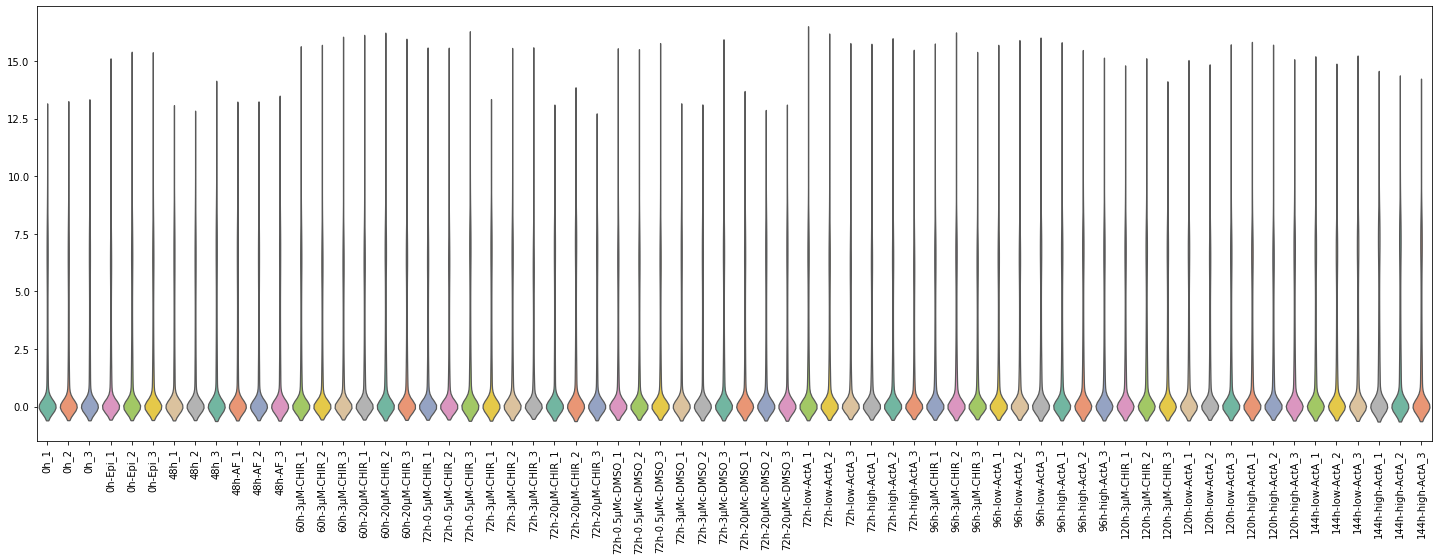

In [8]:
fig,ax=plt.subplots(1,1,figsize=(25,8))

sns.violinplot(log_df.T, palette='Set2',inner=None,ax=ax)
plt.xticks(rotation=90)

plt.savefig(f"results/bulk_logcounts_distribution.{save_format}")

**NORMALIZED COUNTS**

Size factor normalization by median of ratios method

In [9]:
# run deseq2_norm fucntion
dds_norm=deseq2_norm(df_gastruloid)

dds_norm[0].T.to_csv(f"data/normalized_counts.csv")

**SAMPLE REMOVAL**

Remove **48h_AF** and **0h_Epi** conditions for the main analysis (later used for supplementary figures)

In [10]:
#Retain only samples of interest
#Counts
df_gastruloid = df_gastruloid.loc[[(("AF" not in i) and ("Epi" not in i)) and (("ActA" not in i)) and (("96h" not in i)) and (("120h" not in i)) and (("CHIR_5" not in i)) for i in df_gastruloid.index.values]]
#Metadata
df_gastruloid_metadata = df_gastruloid_metadata.loc[[(("AF" not in i) and ("Epi" not in i)) and (("ActA" not in i)) and (("96h" not in i)) and (("120h" not in i)) and (("CHIR_5" not in i)) for i in df_gastruloid_metadata.index]]

# Analysis

## Construct DESeq2 object

In [11]:
dds = DeseqDataSet(
    counts=df_gastruloid.values,
    metadata=df_gastruloid_metadata,
    design_factors="Condition",
    refit_cooks=True
)

/home/paupascualmas/anaconda3/lib/python3.9/site-packages/pydeseq2/dds.py:250: UserWarning: Some factor levels in the design contain underscores ('_').
                    They will be converted to hyphens ('-').
  self.obsm["design_matrix"] = build_design_matrix(


## Variance Stabilizing Transformation (VST)

We scale the data normalizing the sum of total counts and producing and scaling to log1p.

In [12]:
# run vst algorithm
# transformed counts are stored in .layers
dds.vst()

Fitting size factors...
... done in 0.04 seconds.

Fitting dispersions...
... done in 3.86 seconds.

Fitting dispersion trend curve...
... done in 1.76 seconds.



In [13]:
# create df with transformed counts
df1= pd.DataFrame(data=dds.layers['vst_counts'],    
             index=dds.obs.index,    
            columns=df_gastruloid.columns.values)

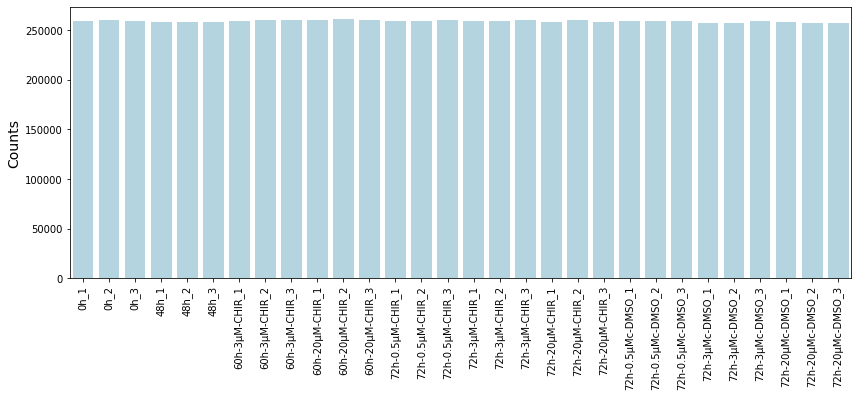

In [14]:
fig,ax=plt.subplots(1,1,figsize=(14,5))
sns.barplot(df1, x=df1.index, y=df1.sum(axis=1),ax=ax, color='lightblue')

plt.xticks(rotation=90)
plt.ylabel('Counts', size=14)
plt.xlabel('')
# create result folder
plt.savefig(f"results/bulk_library_sizes_sizefactoring.{save_format}")

## Feature selection

We use a simple variance threshold to choose the most varying genes.

Free parameters: **threshold**

In [15]:
fs = VarianceThreshold(threshold=1)
fs.fit(df1.values)
l1 = fs.get_feature_names_out()
l = [int(i[1:]) for i in l1]

print(f"Genes retained: {len(l)}")

Genes retained: 796


## PCA

<Axes: >

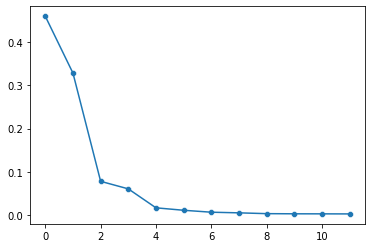

In [16]:
df1_fs = pd.DataFrame(fs.transform(df1.values),index=df1.index,columns=df1.columns.values[l])
pca = PCA(n_components=12)
pca.fit(df1_fs.values)

sns.lineplot(x=np.arange(0,pca.n_components),y=pca.explained_variance_ratio_)
sns.scatterplot(x=np.arange(0,pca.n_components),y=pca.explained_variance_ratio_)

In [17]:
names = df1.columns.values[[int(i[1:]) for i in fs.get_feature_names_out()]]
df1_fs = pd.DataFrame(fs.transform(df1.values),index=df1.index,columns=names)
pca = PCA(n_components=min(4,df1.shape[0]-1))
pca.fit(fs.transform(df1.values));

In [18]:
x = pca.transform(fs.transform(df1.values))

dds.obs['PC1']=x[:,0]
dds.obs['PC2']=x[:,1]

### Representation

Show the PCA components and the Pijuan-Sala projection. The PCA captures time evolution.

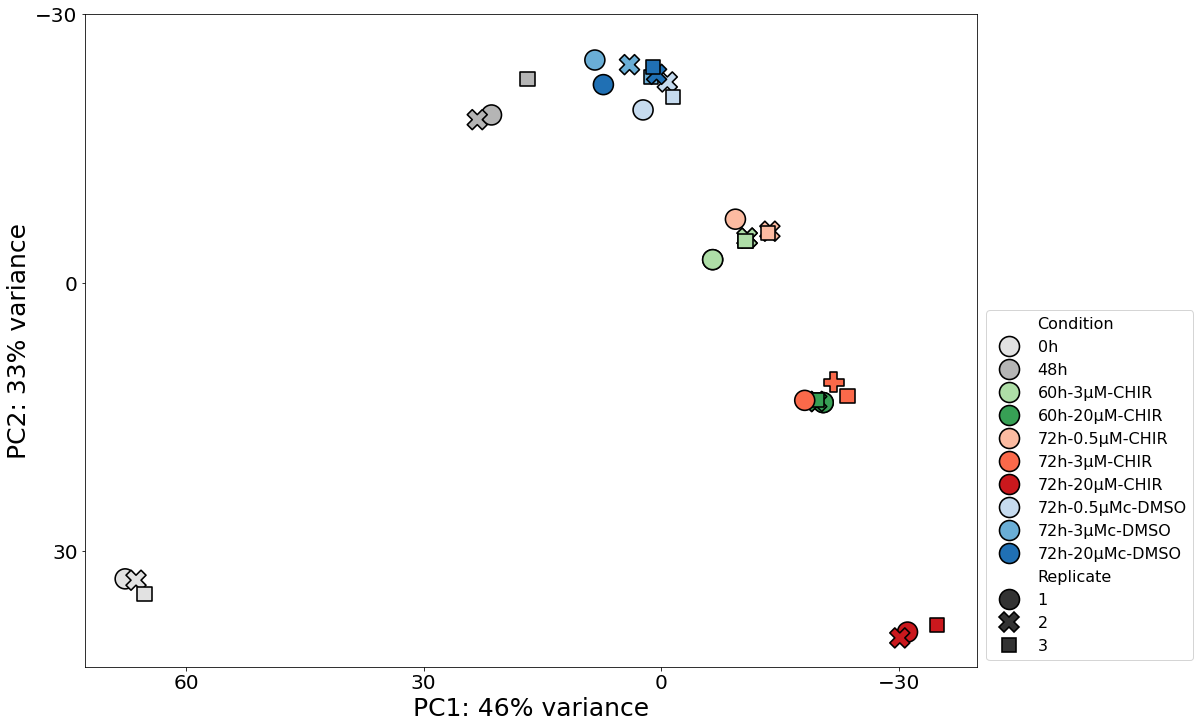

In [19]:
fig,ax=plt.subplots(1,1,figsize=(16,12))
sns.scatterplot(dds.obs[['0h' in i or '48h' in i for i in dds.obs.index.values]],
                       x='PC1', y='PC2', s=400, edgecolor='black',
                       style='Replicate',hue='Condition', ax=ax, palette='Greys')
sns.scatterplot(dds.obs[['60h' in i  for i in dds.obs.index.values]],
                        x='PC1', y='PC2', s=400, edgecolor='black',
                        style='Replicate', hue='Condition', ax=ax, palette='Greens')
sns.scatterplot(dds.obs[['72h' in i and 'CHIR' in i for i in dds.obs.index.values]],
                        x='PC1', y='PC2', s=400, edgecolor='black', 
                        style='Replicate', hue='Condition', ax=ax, palette='Reds')
sns.scatterplot(dds.obs[['72h' in i and 'DMSO' in i for i in dds.obs.index.values]],
                        x='PC1', y='PC2', s=400, edgecolor='black', 
                        style='Replicate', hue='Condition', ax=ax, palette='Blues')

# axes
plt.xlabel(f'PC1: {int(np.round(pca.explained_variance_ratio_[0]*100,decimals=0))}% variance', fontsize=25)
plt.ylabel(f'PC2: {int(np.round(pca.explained_variance_ratio_[1]*100,decimals=0))}% variance', fontsize=25)

#
ax.set_xticks([-30,0, 30, 60])
plt.xticks(fontsize=20)
ax.set_yticks([-30,0, 30])
plt.yticks(fontsize=20)
ax.invert_xaxis()
ax.invert_yaxis()

# legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
# define order
by_label_ord={}
legend_order=['Condition','0h','48h',
          '60h-3μM-CHIR', '60h-20μM-CHIR',
          '72h-0.5μM-CHIR','72h-3μM-CHIR','72h-20μM-CHIR',
          '72h-0.5μMc-DMSO','72h-3μMc-DMSO','72h-20μMc-DMSO',
          'Replicate', '1','2','3'
         ]
by_label_ord=dict((i,by_label[i]) for i in legend_order)
# increase dot size in legend
# for dot in handles:
#     dot.set_sizes(dot.get_sizes() * 10)
# # add black edge to dots in legend
# for ha in handles:
#     ha.set_edgecolor("black")
#     ha.set_linewidth(2)

plt.legend(by_label_ord.values(), by_label_ord.keys(),prop={'size':16}, loc=(1.01,0.01))

plt.savefig(f"results/bulk_analysis_pca_scatterplot.{save_format}",bbox_inches="tight",transparent=True)

### Loadings

This shows that buttom-left to up-right is capturing changes in genes like (T, Wnt3a, etc.) and up-left to bottom-right capturing expressioon of genes like (Hox-family).

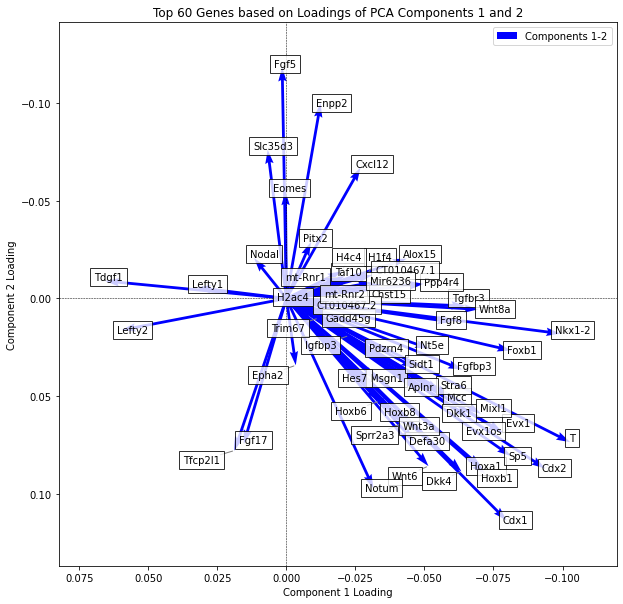

In [20]:
fig, ax = plt.subplots(figsize=(10,10))

plot_loadings_components(pca,0,1,df1_fs.columns.values,60,ax)

ax.invert_xaxis()
ax.invert_yaxis()

plt.savefig(f"results/bulk_analysis_pca_loadings.{save_format}",bbox_inches="tight",transparent=True)

# Marker Genes 

In [21]:
# Marker genes
marker_genes = pd.read_excel("marker_genes.xlsx",sheet_name='chir_72h',header=None).values[:,0]

In [22]:
# conditions to retain for heatmap
retain = ['48h','72h-0.5μMc-DMSO','72h-3μMc-DMSO','72h-20μMc-DMSO','72h-0.5μM-CHIR','72h-3μM-CHIR','72h-20μM-CHIR']

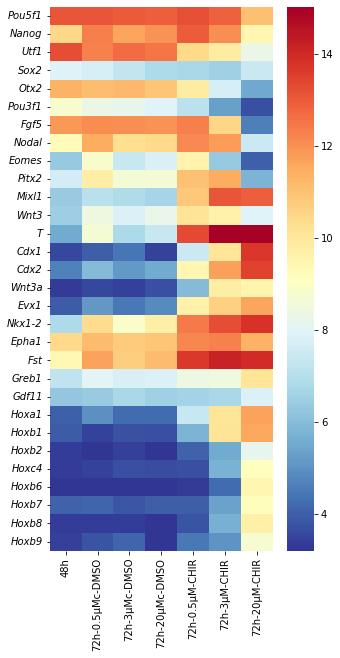

In [23]:
fig, ax = plt.subplots(1,1,figsize=(5,10))

d_ = df1.loc[:,marker_genes].groupby([i[:-2] for i in df_gastruloid_metadata.index]).mean()

g=sns.heatmap(
    d_.loc[retain,:].transpose(),
    cmap="RdYlBu_r"
)
g.set_yticklabels(g.get_yticklabels(), style='italic')

plt.savefig(f"results/bulk_analysis_marker_genes_heatmap.{save_format}",bbox_inches="tight",transparent=True)

# Supplementary figures

### Studying **0h-Epi** and **48h-AF** conditions

**CONSTRUCT DESEQ2 OBJECT AND RUN ALGORITHM**

In [24]:
#Counts
df_gastruloid_ = pd.read_csv("data/gastruloid_bulk.csv",index_col=0).T
df_gastruloid_ = df_gastruloid_.loc[:,~df_gastruloid_.columns.duplicated()].copy() 

#Metadata
df_gastruloid_metadata_ = pd.read_csv("data/gastruloid_bulk_metadata.csv",index_col=0)

#Normalized Counts
# run deseq2_norm function
dds_norm_=deseq2_norm(df_gastruloid_)
dds_norm_[0].to_csv(f"data/normalized_counts_with_af_epi.csv")

# construct DESeq2 object
dds_ = DeseqDataSet(
    counts=df_gastruloid_.values,
    metadata=df_gastruloid_metadata_,
    design_factors="Condition",
    refit_cooks=True
)

# run vst function
dds_.vst()

# df with vst counts
# create df with transformed counts
df1_= pd.DataFrame(data=dds_.layers['vst_counts'],    
             index=dds_.obs.index,    
            columns=df_gastruloid_.columns.values)

/home/paupascualmas/anaconda3/lib/python3.9/site-packages/pydeseq2/dds.py:250: UserWarning: Some factor levels in the design contain underscores ('_').
                    They will be converted to hyphens ('-').
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.03 seconds.

Fitting dispersions...
... done in 4.32 seconds.

Fitting dispersion trend curve...
... done in 1.70 seconds.



**FEATURE SELECTION AND PCA**

In [25]:
## Feature selection
fs_ = VarianceThreshold(threshold=1)
fs_.fit(df1_.values)
l1_ = fs_.get_feature_names_out()
l_ = [int(i[1:]) for i in l1_]

print(f"Genes retained: {len(l_)}")

Genes retained: 620


<Axes: >

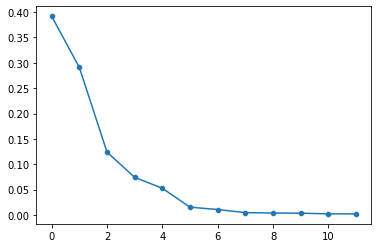

In [26]:
## PCA
df1_fs_ = pd.DataFrame(fs_.transform(df1_.values),index=df1_.index,columns=df1_.columns.values[l_])
pca_ = PCA(n_components=12)
pca_.fit(df1_fs_.values)

sns.lineplot(x=np.arange(0,pca_.n_components),y=pca_.explained_variance_ratio_)
sns.scatterplot(x=np.arange(0,pca_.n_components),y=pca_.explained_variance_ratio_)


In [27]:
names_ = df1_.columns.values[[int(i[1:]) for i in fs_.get_feature_names_out()]]
df1_fs_ = pd.DataFrame(fs_.transform(df1_.values),index=df1_.index,columns=names_)
pca_ = PCA(n_components=min(5,df1_.shape[0]-1))
pca_.fit(fs_.transform(df1_.values));
x_ = pca_.transform(fs_.transform(df1_.values))

dds_.obs['PC1']=x_[:,0]
dds_.obs['PC2']=x_[:,1]

## PCA PLOT

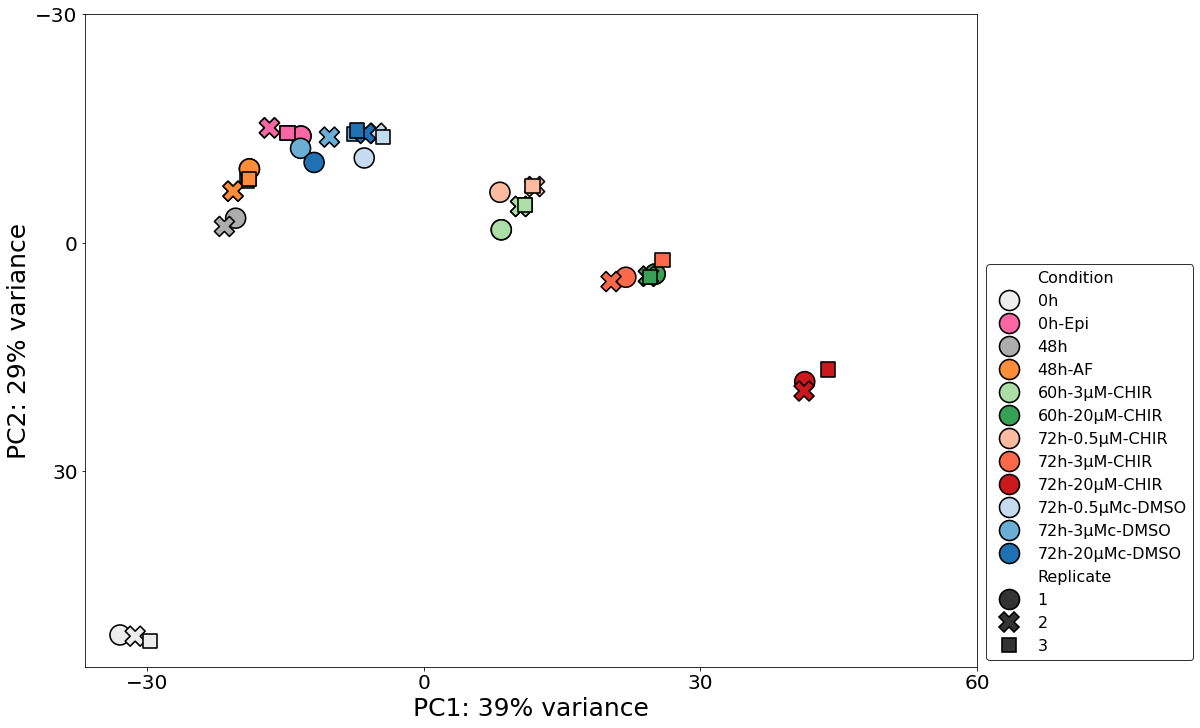

In [28]:
### Representation
fig,ax=plt.subplots(1,1,figsize=(16,12))
sns.scatterplot(dds_.obs[['0h' in i or '48h' in i for i in dds_.obs.index.values]],
                       x='PC1', y='PC2', s=400, edgecolor='black',
                       style='Replicate',hue='Condition', ax=ax, palette='Greys')
sns.scatterplot(dds_.obs[['0h-Epi' in i for i in dds_.obs.index.values]],
                       x='PC1', y='PC2', s=400, edgecolor='black',
                       style='Replicate',hue='Condition', ax=ax, palette='RdPu')
sns.scatterplot(dds_.obs[['48h-AF' in i for i in dds_.obs.index.values]],
                       x='PC1', y='PC2', s=400, edgecolor='black',
                       style='Replicate',hue='Condition', ax=ax, palette='Oranges')
sns.scatterplot(dds_.obs[['60h' in i  for i in dds_.obs.index.values]],
                        x='PC1', y='PC2', s=400, edgecolor='black',
                        style='Replicate', hue='Condition', ax=ax, palette='Greens')
sns.scatterplot(dds_.obs[['72h' in i and 'CHIR' in i for i in dds_.obs.index.values]],
                        x='PC1', y='PC2', s=400, edgecolor='black', 
                        style='Replicate', hue='Condition', ax=ax, palette='Reds')
sns.scatterplot(dds_.obs[['72h' in i and 'DMSO' in i for i in dds_.obs.index.values]],
                        x='PC1', y='PC2', s=400, edgecolor='black', 
                        style='Replicate', hue='Condition', ax=ax, palette='Blues')

# axes
plt.xlabel(f'PC1: {int(np.round(pca_.explained_variance_ratio_[0]*100,decimals=0))}% variance', fontsize=25)
plt.ylabel(f'PC2: {int(np.round(pca_.explained_variance_ratio_[1]*100,decimals=0))}% variance', fontsize=25)

#
ax.set_xticks([-30,0, 30, 60])
plt.xticks(fontsize=20)
ax.set_yticks([-30,0, 30])
plt.yticks(fontsize=20)
#ax.invert_xaxis()
ax.invert_yaxis()

### legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
# define order
by_label_ord={}
legend_order=['Condition','0h','0h-Epi','48h','48h-AF',
          '60h-3μM-CHIR', '60h-20μM-CHIR',
          '72h-0.5μM-CHIR','72h-3μM-CHIR','72h-20μM-CHIR',
          '72h-0.5μMc-DMSO','72h-3μMc-DMSO','72h-20μMc-DMSO',
          'Replicate', '1','2','3'
         ]
by_label_ord=dict((i,by_label[i]) for i in legend_order)
# # increase dot size in legend
# for dot in handles:
#     dot.set_sizes(dot.get_sizes() * 10)
# # add black edge to dots in legend
# for ha in handles:
#     ha.set_edgecolor("black")
#     ha.set_linewidth(2)

plt.legend(by_label_ord.values(), by_label_ord.keys(),prop={'size':16}, loc=(1.01,0.01), markerscale=1.0, edgecolor="black")

plt.savefig(f"results/bulk_analysis_pca_scatterplot_with_af_epi.{save_format}",bbox_inches="tight",transparent=True)

## Marker Genes for Epi and AF

In [29]:
# Marker genes
marker_af_epi = pd.read_excel("marker_genes.xlsx",sheet_name='af_epi',header=None).values[:,0]

In [30]:
# conditions to retain for plotting heatmap
retain = ['0h','48h','48h-AF', '0h-Epi']

## CHIR vs DMSO

In [31]:
markers_chir_dmso=pd.read_excel("marker_genes.xlsx",sheet_name='chir_dmso',header=None).values[:,0]

In [32]:
retain=['48h_1','48h_2','48h_3',
           '72h-3μMc-DMSO_1','72h-3μMc-DMSO_2','72h-3μMc-DMSO_3',  
            '72h-20μMc-DMSO_1','72h-20μMc-DMSO_2','72h-20μMc-DMSO_3',
           '72h-3μM-CHIR_1','72h-3μM-CHIR_2','72h-3μM-CHIR_3', 
           '72h-20μM-CHIR_1','72h-20μM-CHIR_2','72h-20μM-CHIR_3']

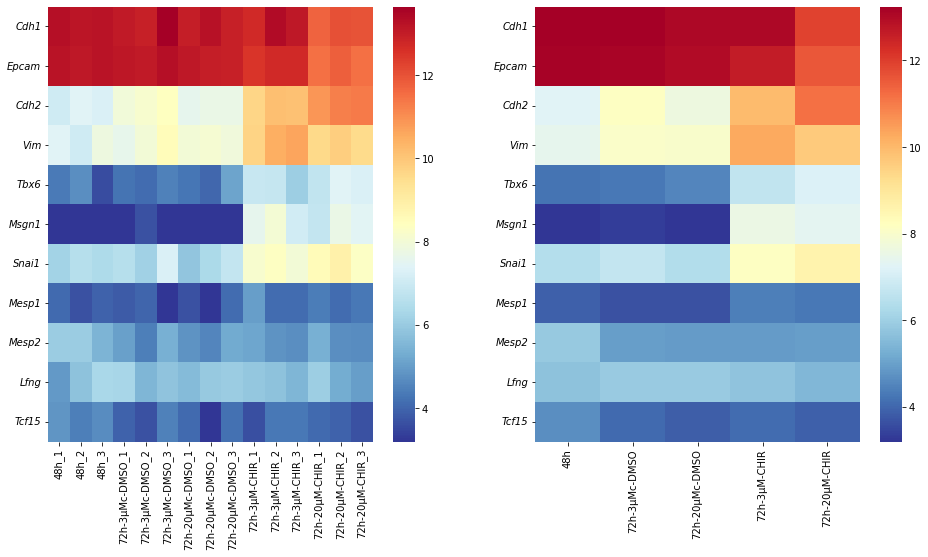

In [33]:
# retain samples of interest
d_s = df1.loc[:,markers_chir_dmso]
d_s_mean = df1.loc[:,markers_chir_dmso].groupby([i[:-2] for i in df1.index]).mean()

fig,ax=plt.subplots(1,2, figsize=(16,8))
sns.heatmap(
    d_s.loc[retain].transpose(),
    cmap="RdYlBu_r",
    ax=ax[0],
)
ax[0].set(xlabel=None)
ax[0].tick_params('y', labelrotation=0)
ax[0].set_yticklabels(ax[0].get_yticklabels(),style='italic')
sns.heatmap(
    d_s_mean.loc[['48h','72h-3μMc-DMSO','72h-20μMc-DMSO','72h-3μM-CHIR', '72h-20μM-CHIR']].transpose(),
    cmap="RdYlBu_r",
    ax=ax[1]
)
ax[1].tick_params('y', labelrotation=0)
ax[1].set_yticklabels(ax[1].get_yticklabels(),style='italic')

plt.savefig(f"results/bulk_analysis_heatmap_chir_dmso.{save_format}",bbox_inches="tight",transparent=True)

# CHIR3 vs CHIR20

In [34]:
retain=['72h-3μM-CHIR_1','72h-3μM-CHIR_2','72h-3μM-CHIR_3', 
        '72h-20μM-CHIR_1','72h-20μM-CHIR_2','72h-20μM-CHIR_3']

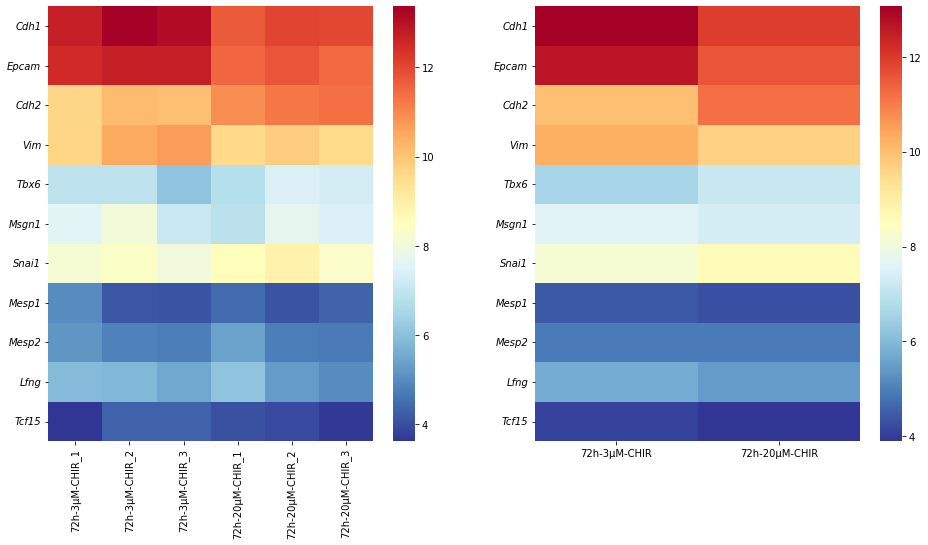

In [35]:
# retain samples of interest
d_s = df1.loc[[i in retain for i in df1.index],markers_chir_dmso]
d_s_mean = d_s.groupby([i[:-2] for i in d_s.index]).mean()

fig,ax=plt.subplots(1,2, figsize=(16,8))
sns.heatmap(
    d_s.loc[retain].transpose(),
    cmap="RdYlBu_r", 
    ax=ax[0],
)
ax[0].set(xlabel=None)
ax[0].tick_params('y', labelrotation=0)
ax[0].set_yticklabels(ax[0].get_yticklabels(), style='italic')
sns.heatmap(
    d_s_mean.loc[['72h-3μM-CHIR','72h-20μM-CHIR']].transpose(),
    cmap="RdYlBu_r",
    ax=ax[1]
)
ax[1].tick_params('y', labelrotation=0)
ax[1].set_yticklabels(ax[1].get_yticklabels(), style='italic')

plt.savefig(f"results/bulk_analysis_heatmap_chir3_vs_chir20.{save_format}",bbox_inches="tight",transparent=True)

# Chir 60h and 72h

In [36]:
markers_c_60_72h=pd.read_excel("marker_genes.xlsx",sheet_name='chir_60h_72h',header=None).values[:,0]

In [37]:
retain=['48h_1','48h_2','48h_3',
        '60h-3μM-CHIR_2', '60h-3μM-CHIR_3', '60h-20μM-CHIR_1', 
           '72h-3μM-CHIR_1','72h-3μM-CHIR_2','72h-3μM-CHIR_3', 
'72h-3μMc-DMSO_1','72h-3μMc-DMSO_2','72h-3μMc-DMSO_3']

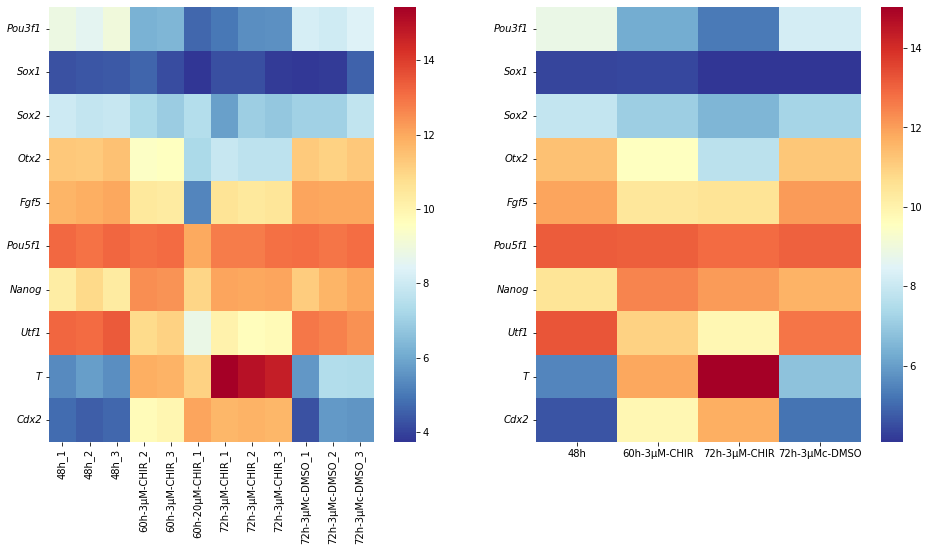

In [38]:
# retain samples of interest
d_s = df1.loc[[i in retain for i in df1.index],markers_c_60_72h]
d_s_mean = d_s.groupby([i[:-2] for i in d_s.index]).mean()

fig,ax=plt.subplots(1,2, figsize=(16,8))
sns.heatmap(
    d_s.loc[retain].transpose(),
    cmap="RdYlBu_r", 
    ax=ax[0],
)
ax[0].set(xlabel=None)
ax[0].tick_params('y', labelrotation=0)
ax[0].set_yticklabels(ax[0].get_yticklabels(), style='italic')

sns.heatmap(
    d_s_mean.loc[['48h','60h-3μM-CHIR','72h-3μM-CHIR','72h-3μMc-DMSO']].transpose(),
    cmap="RdYlBu_r",
    ax=ax[1]
)
ax[1].tick_params('y', labelrotation=0)
ax[1].set_yticklabels(ax[1].get_yticklabels(), style='italic')

plt.savefig(f"results/bulk_analysis_heatmap_48h_60hchir_72h.{save_format}",bbox_inches="tight",transparent=True)

# ACT VS CHIR

In [39]:
#Counts
df_gastruloid = pd.read_csv("data/chir_act_counts.csv",index_col=0).T
df_gastruloid = df_gastruloid.loc[:,~df_gastruloid.columns.duplicated()].copy() #Remove potentially duplicated genes names (very few and irrelevant genes are duplicated)

In [40]:
#Metadata
df_gastruloid_metadata = pd.read_csv("data/metadata_chir_new.csv",index_col=0)

In [41]:
retain=['48h_1','48h_2','48h_3',
        '72h-0.5μM-CHIR_1','72h-0.5μM-CHIR_2', '72h-0.5μM-CHIR_3',
          '72h-3μM-CHIR_1','72h-3μM-CHIR_2','72h-3μM-CHIR_3','72h-3μM-CHIR_5', 
          '72h-3μMc-DMSO_1','72h-3μMc-DMSO_2','72h-3μMc-DMSO_3',
         '72h-low-ActA_1','72h-low-ActA_2','72h-low-ActA_3',
          '72h-high-ActA_1','72h-high-ActA_2','72h-high-ActA_3',
          '96h-3μM-CHIR_1','96h-3μM-CHIR_2','96h-3μM-CHIR_3',
          '96h-low-ActA_1','96h-low-ActA_2','96h-low-ActA_3',
          '96h-high-ActA_1','96h-high-ActA_2','96h-high-ActA_3',
           '120h-3μM-CHIR_1','120h-3μM-CHIR_2','120h-3μM-CHIR_3',
           '120h-low-ActA_1','120h-low-ActA_2','120h-low-ActA_3',
           '120h-high-ActA_1','120h-high-ActA_2','120h-high-ActA_3',
           '144h-low-ActA_1','144h-low-ActA_2','144h-low-ActA_3',
          '144h-high-ActA_1','144h-high-ActA_2','144h-high-ActA_3'
          ] 

In [42]:
# retain=['48h_1','48h_2','48h_3',
#           '72h-3μMc-DMSO_1','72h-3μMc-DMSO_2','72h-3μMc-DMSO_3',
#         '72h-0.5μM-CHIR_1','72h-0.5μM-CHIR_2', '72h-0.5μM-CHIR_3',
#           '72h-3μM-CHIR_1','72h-3μM-CHIR_2','72h-3μM-CHIR_3','72h-3μM-CHIR_5', 
#           '72h-high-ActA_1','72h-high-ActA_2','72h-high-ActA_3',
#           '96h-3μM-CHIR_1','96h-3μM-CHIR_2','96h-3μM-CHIR_3',
#           '96h-high-ActA_1','96h-high-ActA_2','96h-high-ActA_3',
#           '120h-3μM-CHIR_1','120h-3μM-CHIR_2','120h-3μM-CHIR_3',
#           '120h-high-ActA_1','120h-high-ActA_2','120h-high-ActA_3',
#           ] 

In [43]:
df_gastruloid = df_gastruloid[[i in retain for i in df_gastruloid.index]]
df_gastruloid_metadata=df_gastruloid_metadata[[i in retain for i in df_gastruloid_metadata.index]]

# Normalized table

In [44]:
# run deseq2_norm fucntion
dds_norm=deseq2_norm(df_gastruloid)

dds_norm[0].T.to_csv(f"data/normalized_counts_act_chir.csv")

# DDS object

In [45]:
dds = DeseqDataSet(
    counts=df_gastruloid.values,
    metadata=df_gastruloid_metadata,
    design_factors="Condition",
    refit_cooks=True
)
dds.var_names=df_gastruloid.columns

/home/paupascualmas/anaconda3/lib/python3.9/site-packages/pydeseq2/dds.py:250: UserWarning: Some factor levels in the design contain underscores ('_').
                    They will be converted to hyphens ('-').
  self.obsm["design_matrix"] = build_design_matrix(


# VST

In [46]:
dds.vst()
# create df with transformed counts
df1= pd.DataFrame(data=dds.layers['vst_counts'],    
             index=dds.obs.index,    
            columns=df_gastruloid.columns.values)


Fitting size factors...
... done in 0.05 seconds.

Fitting dispersions...
... done in 5.06 seconds.

Fitting dispersion trend curve...
... done in 2.59 seconds.



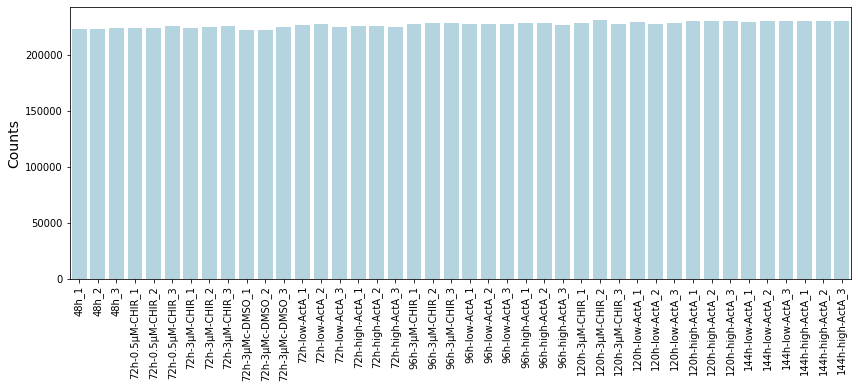

In [47]:
fig,ax=plt.subplots(1,1,figsize=(14,5))
sns.barplot(df1, x=df1.index, y=df1.sum(axis=1),ax=ax, color='lightblue')

plt.xticks(rotation=90)
plt.ylabel('Counts', size=14)
plt.xlabel('')
# create result folder
plt.savefig(f"results/bulk_library_sizes_sizefactoring_act_vs_chir.{save_format}")

In [48]:
fs = VarianceThreshold(threshold=1.5)
fs.fit(df1.values)
l1 = fs.get_feature_names_out()
l = [int(i[1:]) for i in l1]

print(f"Genes retained: {len(l)}")

Genes retained: 1108


<Axes: >

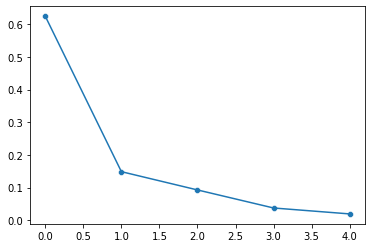

In [49]:

df1_fs = pd.DataFrame(fs.transform(df1.values),index=df1.index,columns=df1.columns.values[l])
pca = PCA(n_components=5)
pca.fit(df1_fs.values)

sns.lineplot(x=np.arange(0,pca.n_components),y=pca.explained_variance_ratio_)
sns.scatterplot(x=np.arange(0,pca.n_components),y=pca.explained_variance_ratio_)


In [50]:
names = df1.columns.values[[int(i[1:]) for i in fs.get_feature_names_out()]]
df1_fs = pd.DataFrame(fs.transform(df1.values),index=df1.index,columns=names)
pca = PCA(n_components=min(4,df1.shape[0]-1))
pca.fit(fs.transform(df1.values));

In [51]:
x = pca.transform(fs.transform(df1.values))

dds.obs['PC1']=x[:,0]
dds.obs['PC2']=x[:,1]

# PCA plot

# 1st

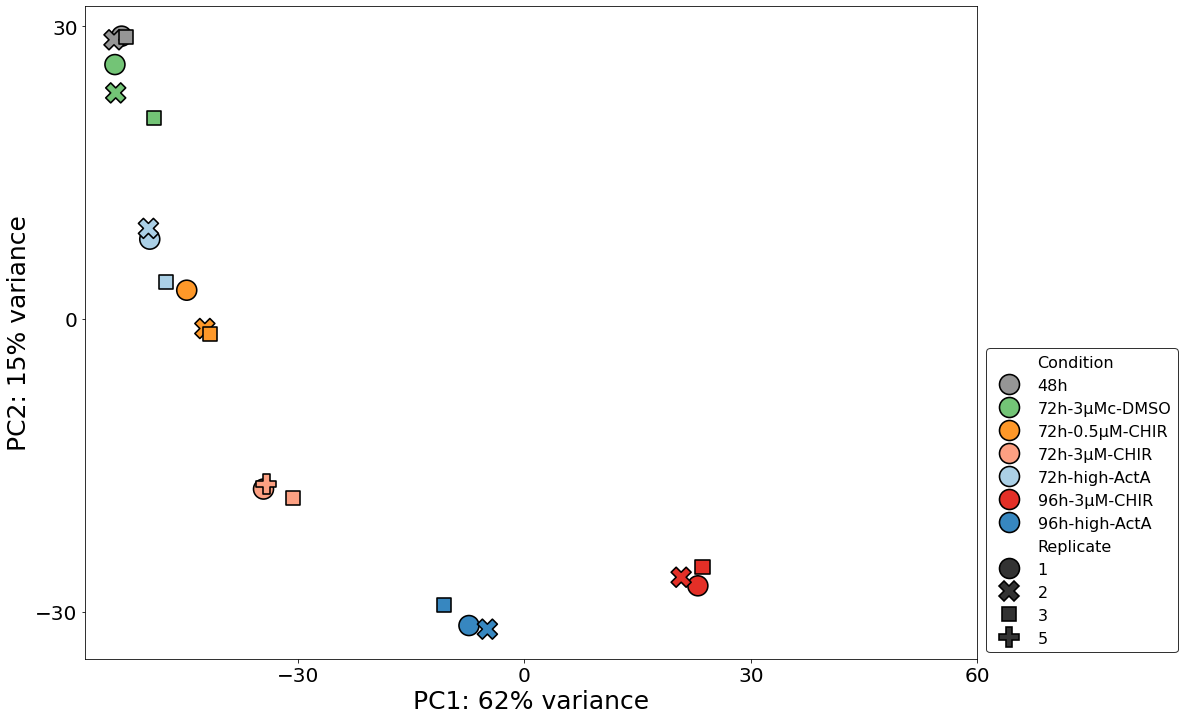

In [52]:
### Representation
fig,ax=plt.subplots(1,1,figsize=(16,12))
sns.scatterplot(dds.obs[['48h' in i for i in dds.obs.index.values]],
                       x='PC1', y='PC2', s=400, edgecolor='black',
                       style='Replicate',hue='Condition', ax=ax, palette='Greys')
sns.scatterplot(dds.obs[[('72h-3μM-CHIR' in i) or ('96h-3μM-CHIR' in i) for i in dds.obs.index.values]],
                     x='PC1', y='PC2', s=400, edgecolor='black', 
                        style='Replicate', hue='Condition', ax=ax, palette='Reds')
sns.scatterplot(dds.obs[[('0.5μM-CHIR' in i) for i in dds.obs.index.values]],
                     x='PC1', y='PC2', s=400, edgecolor='black', 
                        style='Replicate', hue='Condition', ax=ax, palette='YlOrBr')
sns.scatterplot(dds.obs[['DMSO' in i for i in dds.obs.index.values]],
                     x='PC1', y='PC2', s=400, edgecolor='black', 
                        style='Replicate', hue='Condition', ax=ax, palette='Greens')
# sns.scatterplot(dds.obs[['low-ActA' in i for i in dds.obs.index.values]],
#                         x='PC1', y='PC2', s=400, edgecolor='black', 
#                         style='Replicate', hue='Condition', ax=ax, palette='Greens')
sns.scatterplot(dds.obs[[('72h-high-ActA' in i) or ('96h-high-ActA' in i) for i in dds.obs.index.values]],
                        x='PC1', y='PC2', s=400, edgecolor='black', 
                        style='Replicate', hue='Condition', ax=ax, palette='Blues')
# axes
plt.xlabel(f'PC1: {int(np.round(pca.explained_variance_ratio_[0]*100,decimals=0))}% variance', fontsize=25)
plt.ylabel(f'PC2: {int(np.round(pca.explained_variance_ratio_[1]*100,decimals=0))}% variance', fontsize=25)
#
ax.set_xticks([-30,0, 30, 60])
plt.xticks(fontsize=20)
ax.set_yticks([-30,0, 30])
plt.yticks(fontsize=20)
#ax.invert_xaxis()
#ax.invert_yaxis()

### legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
# define order
by_label_ord={}
legend_order=['Condition','48h','72h-3μMc-DMSO',
              '72h-0.5μM-CHIR','72h-3μM-CHIR', '72h-high-ActA',
          '96h-3μM-CHIR','96h-high-ActA',
          'Replicate', '1','2','3','5'
         ]
# legend_order=['Condition','48h','72h-0.5μM-CHIR'
#              '72h-3μM-CHIR','72h-low-ActA', '72h-high-ActA',
#           '96h-3μM-CHIR','96h-low-ActA','96h-high-ActA',
#           '120h-3μM-CHIR','120h-low-ActA','120h-high-ActA',
#           '144h-low-ActA', '144h-high-ActA',
#           'Replicate', '1','2','3'
#          ]
by_label_ord=dict((i,by_label[i]) for i in legend_order)
# # increase dot size in legend
# for dot in handles:
#     dot.set_sizes(dot.get_sizes() * 10)
# # add black edge to dots in legend
# for ha in handles:
#     ha.set_edgecolor("black")
#     ha.set_linewidth(2)

plt.legend(by_label_ord.values(), by_label_ord.keys(),prop={'size':16}, loc=(1.01,0.01), markerscale=1.0, edgecolor="black")

plt.savefig(f"results/bulk_analysis_pca_scatterplot_act_high_vs_chir_72h_96h.{save_format}",bbox_inches="tight",transparent=True)

# 1st: Loadings

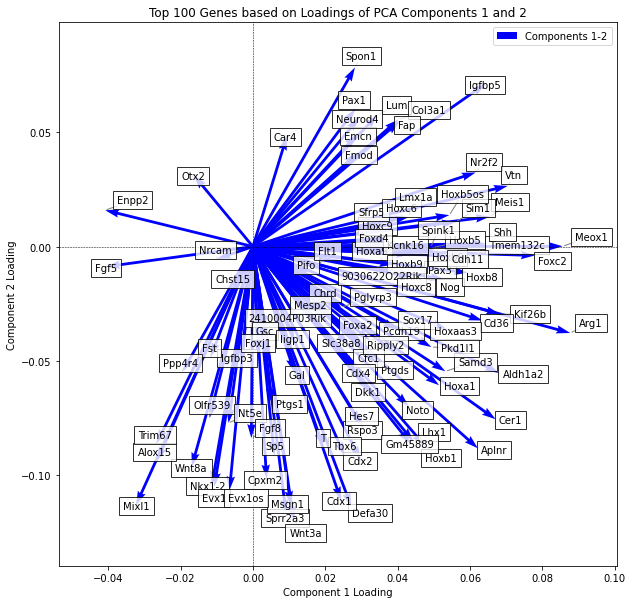

In [53]:
fig, ax = plt.subplots(figsize=(10,10))

plot_loadings_components(pca,0,1,df1_fs.columns.values,100,ax)

#ax.invert_yaxis()

plt.savefig(f"results/bulk_analysis_pca_100loadings_act_vs_chir_72h_96h.{save_format}",bbox_inches="tight",transparent=True)

# 2nd 

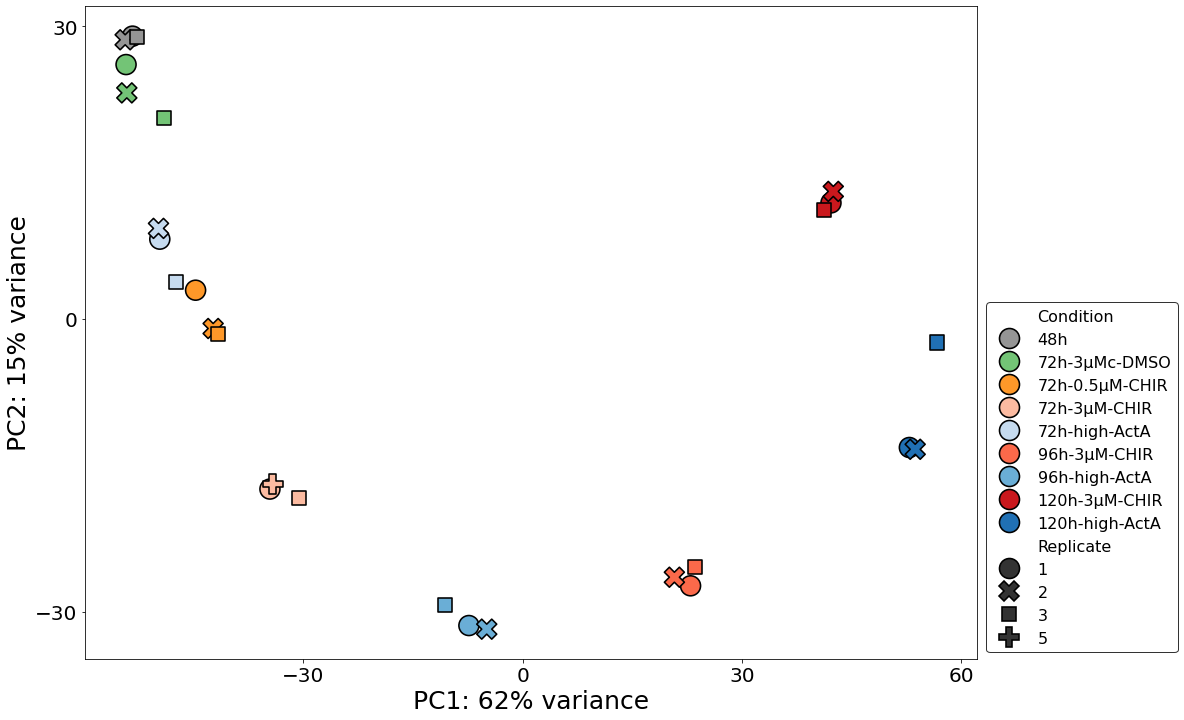

In [54]:
### Representation
fig,ax=plt.subplots(1,1,figsize=(16,12))
sns.scatterplot(dds.obs[['48h' in i for i in dds.obs.index.values]],
                       x='PC1', y='PC2', s=400, edgecolor='black',
                       style='Replicate',hue='Condition', ax=ax, palette='Greys')
sns.scatterplot(dds.obs[[('72h-3μM-CHIR' in i) or ('96h-3μM-CHIR' in i) or ('120h-3μM-CHIR' in i) for i in dds.obs.index.values]],
                     x='PC1', y='PC2', s=400, edgecolor='black', 
                        style='Replicate', hue='Condition', ax=ax, palette='Reds')
sns.scatterplot(dds.obs[[('0.5μM-CHIR' in i) for i in dds.obs.index.values]],
                     x='PC1', y='PC2', s=400, edgecolor='black', 
                        style='Replicate', hue='Condition', ax=ax, palette='YlOrBr')
sns.scatterplot(dds.obs[['DMSO' in i for i in dds.obs.index.values]],
                     x='PC1', y='PC2', s=400, edgecolor='black', 
                        style='Replicate', hue='Condition', ax=ax, palette='Greens')
# sns.scatterplot(dds.obs[['low-ActA' in i for i in dds.obs.index.values]],
#                         x='PC1', y='PC2', s=400, edgecolor='black', 
#                         style='Replicate', hue='Condition', ax=ax, palette='Greens')
sns.scatterplot(dds.obs[[('72h-high-ActA' in i) or ('96h-high-ActA' in i) or ('120h-high-ActA' in i) for i in dds.obs.index.values]],
                        x='PC1', y='PC2', s=400, edgecolor='black', 
                        style='Replicate', hue='Condition', ax=ax, palette='Blues')
# axes
plt.xlabel(f'PC1: {int(np.round(pca.explained_variance_ratio_[0]*100,decimals=0))}% variance', fontsize=25)
plt.ylabel(f'PC2: {int(np.round(pca.explained_variance_ratio_[1]*100,decimals=0))}% variance', fontsize=25)
#
ax.set_xticks([-30,0, 30, 60])
plt.xticks(fontsize=20)
ax.set_yticks([-30,0, 30])
plt.yticks(fontsize=20)
#ax.invert_xaxis()
#ax.invert_yaxis()

### legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
# define order
by_label_ord={}
legend_order=['Condition','48h','72h-3μMc-DMSO',
              '72h-0.5μM-CHIR','72h-3μM-CHIR', '72h-high-ActA',
          '96h-3μM-CHIR','96h-high-ActA', 
          '120h-3μM-CHIR','120h-high-ActA', 
          'Replicate', '1','2','3','5'
         ]
# legend_order=['Condition','48h','72h-0.5μM-CHIR'
#              '72h-3μM-CHIR','72h-low-ActA', '72h-high-ActA',
#           '96h-3μM-CHIR','96h-low-ActA','96h-high-ActA',
#           '120h-3μM-CHIR','120h-low-ActA','120h-high-ActA',
#           '144h-low-ActA', '144h-high-ActA',
#           'Replicate', '1','2','3'
#          ]
by_label_ord=dict((i,by_label[i]) for i in legend_order)
# # increase dot size in legend
# for dot in handles:
#     dot.set_sizes(dot.get_sizes() * 10)
# # add black edge to dots in legend
# for ha in handles:
#     ha.set_edgecolor("black")
#     ha.set_linewidth(2)

plt.legend(by_label_ord.values(), by_label_ord.keys(),prop={'size':16}, loc=(1.01,0.01), markerscale=1.0, edgecolor="black")

plt.savefig(f"results/bulk_analysis_pca_scatterplot_act_high_vs_chir_72h_96h_120h.{save_format}",bbox_inches="tight",transparent=True)

# 2nd: Loadings

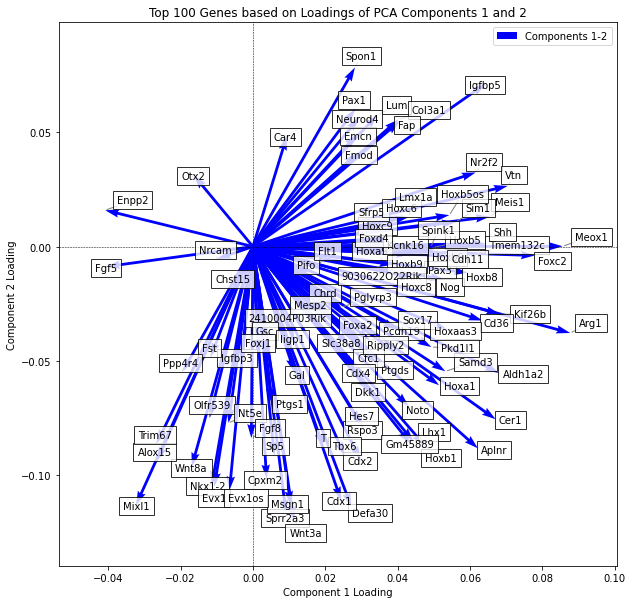

In [55]:
fig, ax = plt.subplots(figsize=(10,10))

plot_loadings_components(pca,0,1,df1_fs.columns.values,100,ax)

#ax.invert_yaxis()

plt.savefig(f"results/bulk_analysis_pca_100loadings_act_vs_chir_72h_96h_120h.{save_format}",bbox_inches="tight",transparent=True)

# 3rd: CHIR3 VS high-ActA

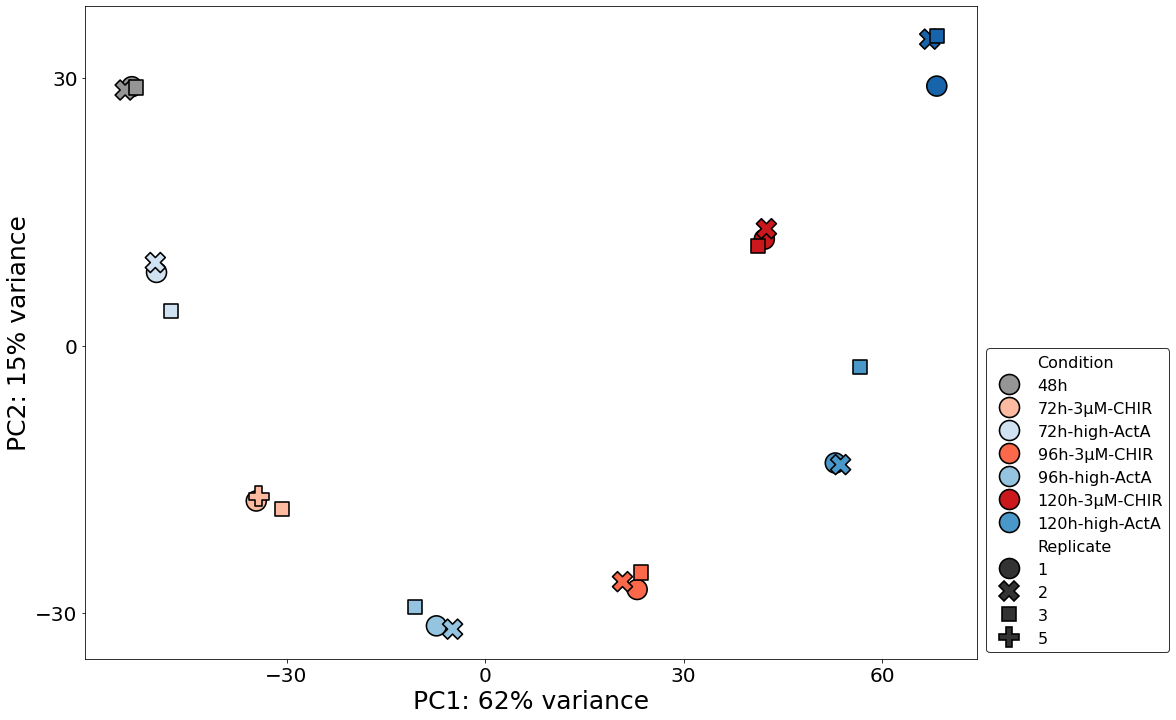

In [56]:
### Representation
fig,ax=plt.subplots(1,1,figsize=(16,12))
sns.scatterplot(dds.obs[['48h' in i for i in dds.obs.index.values]],
                       x='PC1', y='PC2', s=400, edgecolor='black',
                       style='Replicate',hue='Condition', ax=ax, palette='Greys')
sns.scatterplot(dds.obs[[('3μM-CHIR' in i) for i in dds.obs.index.values]],
                     x='PC1', y='PC2', s=400, edgecolor='black', 
                        style='Replicate', hue='Condition', ax=ax, palette='Reds')
# sns.scatterplot(dds.obs[['low-ActA' in i for i in dds.obs.index.values]],
#                         x='PC1', y='PC2', s=400, edgecolor='black', 
#                         style='Replicate', hue='Condition', ax=ax, palette='Greens')
sns.scatterplot(dds.obs[['high-ActA' in i for i in dds.obs.index.values]],
                        x='PC1', y='PC2', s=400, edgecolor='black', 
                        style='Replicate', hue='Condition', ax=ax, palette='Blues')
# axes
plt.xlabel(f'PC1: {int(np.round(pca.explained_variance_ratio_[0]*100,decimals=0))}% variance', fontsize=25)
plt.ylabel(f'PC2: {int(np.round(pca.explained_variance_ratio_[1]*100,decimals=0))}% variance', fontsize=25)
#
ax.set_xticks([-30,0, 30, 60])
plt.xticks(fontsize=20)
ax.set_yticks([-30,0, 30])
plt.yticks(fontsize=20)
#ax.invert_xaxis()
#ax.invert_yaxis()

### legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
# define order
by_label_ord={}
legend_order=['Condition','48h','72h-3μM-CHIR', '72h-high-ActA',
          '96h-3μM-CHIR','96h-high-ActA','120h-3μM-CHIR','120h-high-ActA',
          'Replicate', '1','2','3','5'
         ]
# legend_order=['Condition','48h','72h-0.5μM-CHIR'
#              '72h-3μM-CHIR','72h-low-ActA', '72h-high-ActA',
#           '96h-3μM-CHIR','96h-low-ActA','96h-high-ActA',
#           '120h-3μM-CHIR','120h-low-ActA','120h-high-ActA',
#           '144h-low-ActA', '144h-high-ActA',
#           'Replicate', '1','2','3'
#          ]
by_label_ord=dict((i,by_label[i]) for i in legend_order)
# # increase dot size in legend
# for dot in handles:
#     dot.set_sizes(dot.get_sizes() * 10)
# # add black edge to dots in legend
# for ha in handles:
#     ha.set_edgecolor("black")
#     ha.set_linewidth(2)

plt.legend(by_label_ord.values(), by_label_ord.keys(),prop={'size':16}, loc=(1.01,0.01), markerscale=1.0, edgecolor="black")

plt.savefig(f"results/bulk_analysis_pca_scatterplot_act_high_vs_chir3_72h-120h.{save_format}",bbox_inches="tight",transparent=True)

# 3rd: Loadings

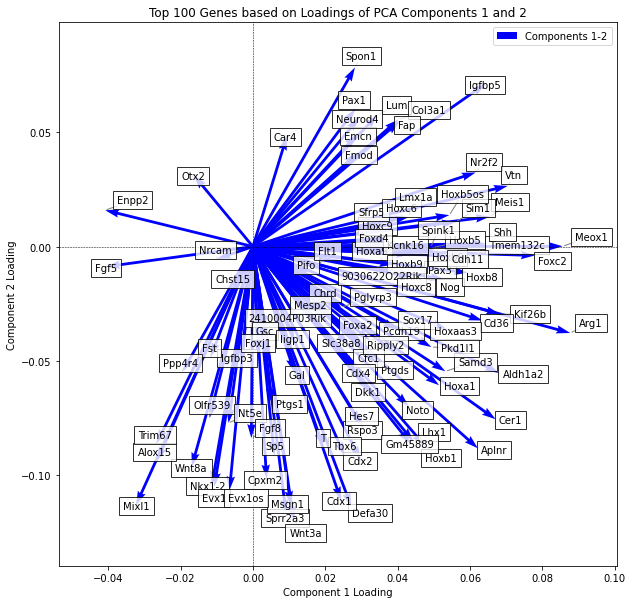

In [57]:
fig, ax = plt.subplots(figsize=(10,10))

plot_loadings_components(pca,0,1,df1_fs.columns.values,100,ax)

#ax.invert_yaxis()

plt.savefig(f"results/bulk_analysis_pca_100loadings_act_vs_chir3_72h-120h.{save_format}",bbox_inches="tight",transparent=True)

# PAIR-WISE COMPARISON

In [58]:
dds.deseq2()

Fitting size factors...
... done in 0.05 seconds.

Fitting dispersions...
... done in 4.51 seconds.

Fitting dispersion trend curve...
... done in 1.07 seconds.

Fitting MAP dispersions...
... done in 5.70 seconds.

Fitting LFCs...
... done in 4.46 seconds.

Refitting 0 outliers.



In [59]:
LFC_THRES=0.5
PADJ_THRES=0.1

In [60]:
contrasts=[('Condition','72h-low-ActA','48h'),
           ('Condition','72h-high-ActA','48h'),
           ('Condition','72h-low-ActA','72h-3μM-CHIR'),
            ('Condition','72h-0.5μM-CHIR','72h-3μM-CHIR'),
            ('Condition','72h-high-ActA','72h-0.5μM-CHIR'),
            ('Condition', '72h-high-ActA','72h-3μMc-DMSO'),
           ('Condition','72h-high-ActA','72h-3μM-CHIR'),
           ('Condition', '72h-low-ActA', '72h-high-ActA'),
           ('Condition','72h-high-ActA','96h-high-ActA'),
           ('Condition','96h-high-ActA','96h-3μM-CHIR'),
           ('Condition','96h-high-ActA','96h-low-ActA'),
           ('Condition','120h-high-ActA','96h-high-ActA'),
           ('Condition','120h-high-ActA','120h-low-ActA'),
           ('Condition','120h-high-ActA','120h-3μM-CHIR'),
           ('Condition','144h-high-ActA','120h-high-ActA'),
           ('Condition','144h-high-ActA','144h-low-ActA')]


# Rank genes and compute DEGs

In [61]:
os.makedirs('results/pair-wise',exist_ok=True)

In [62]:
for c in contrasts:
    # set up statistical on constrast
    stat_res=DeseqStats(dds, contrast=c,quiet=True)
    # run t-test
    stat_res.summary()
    
    # results df, sorted by lfc
    res=stat_res.results_df
    res.index=df1.columns #reset genenames, they get lost
    res=res.sort_values(by='log2FoldChange', ascending=False)
    res['-log10P']=-np.log10(res.pvalue)
    res=res[res.baseMean>100]

    #DEGs subsetting
    degs=res[(abs(res['log2FoldChange'])>LFC_THRES) & (res['pvalue']<PADJ_THRES)]

    # save tables
    res.to_csv(f"results/pair-wise/ranked_{c[1]}_vs_{c[2]}.csv")
    degs.to_csv(f"results/pair-wise/degs_{c[1]}_vs_{c[2]}.csv")

Log2 fold change & Wald test p-value: Condition 72h-low-ActA vs 48h
                  baseMean  log2FoldChange     lfcSE      stat        pvalue  \
Gene                                                                           
4933401J01Rik     0.000000             NaN       NaN       NaN           NaN   
Gm26206           0.000000             NaN       NaN       NaN           NaN   
Xkr4             35.455591        2.479241  0.498085  4.977546  6.439542e-07   
Gm18956           0.263204        1.434016  8.005473  0.179129  8.578360e-01   
Gm37180           2.861041        2.080503  1.233910  1.686106  9.177538e-02   
...                    ...             ...       ...       ...           ...   
AC124606.1        0.000000             NaN       NaN       NaN           NaN   
AC133095.2        0.358011       -1.889689  7.342023 -0.257380  7.968856e-01   
AC133095.1        0.000000             NaN       NaN       NaN           NaN   
AC234645.1        0.000000             NaN       NaN

## Volcano plot: 72h high vs low ActA

### PAIR-WISE COMPARISON

In [63]:
stat_res=DeseqStats(dds, contrast=('Condition', '72h-high-ActA', '72h-low-ActA'),quiet=True)
# run t-test
stat_res.summary()

# results df, sorted by lfc
res_df=stat_res.results_df

Log2 fold change & Wald test p-value: Condition 72h-high-ActA vs 72h-low-ActA
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Gene                                                                       
4933401J01Rik     0.000000             NaN       NaN       NaN       NaN   
Gm26206           0.000000             NaN       NaN       NaN       NaN   
Xkr4             35.455591        0.065495  0.445709  0.146946  0.883175   
Gm18956           0.263204       -0.759131  8.004518 -0.094838  0.924444   
Gm37180           2.861041       -1.068228  1.187515 -0.899549  0.368360   
...                    ...             ...       ...       ...       ...   
AC124606.1        0.000000             NaN       NaN       NaN       NaN   
AC133095.2        0.358011       -0.759133  7.571846 -0.100257  0.920140   
AC133095.1        0.000000             NaN       NaN       NaN       NaN   
AC234645.1        0.000000             NaN       NaN       NaN       NaN   
AC149090.1

In [64]:
import importlib,sys
from importlib import reload
importlib.reload(sys.modules['custom_functions'])
from custom_functions import *


(<Figure size 1080x1080 with 1 Axes>,
 <Axes: title={'center': 'LFC threshold: 2 // p-value threshold: 0.05 // DEGs: 15/15291'}, xlabel='log2FoldChange', ylabel='-log10P'>)

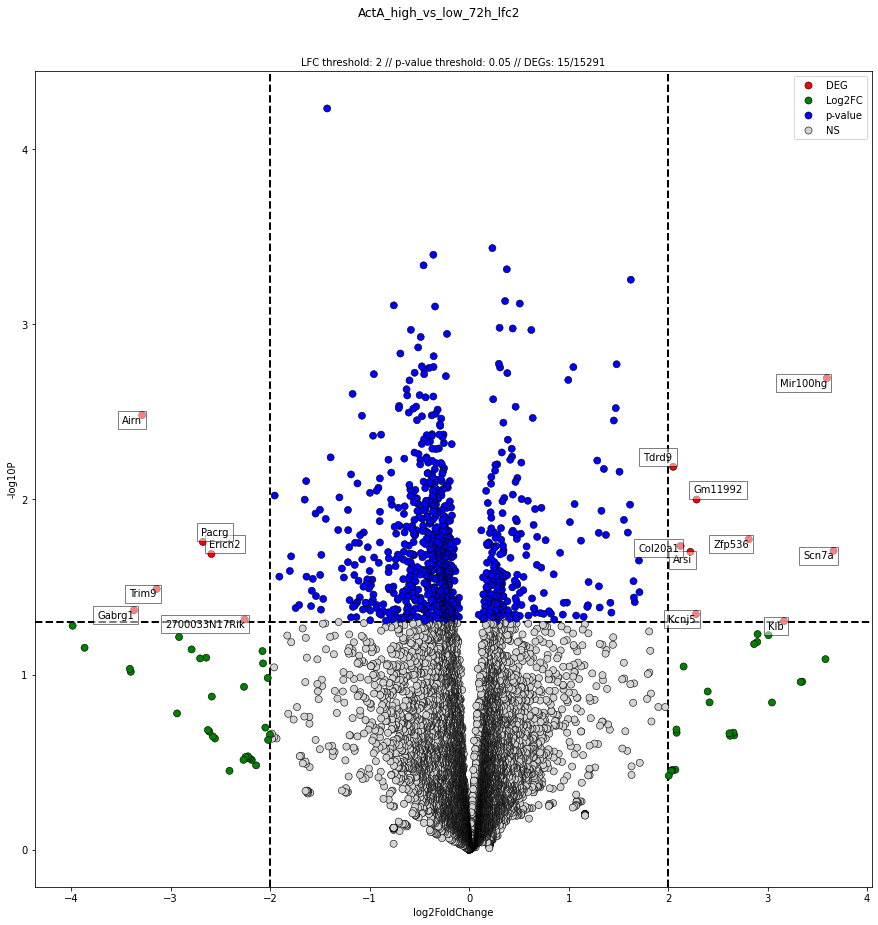

In [66]:
# plot volcano
plot_volcano(res_df, lfc_threshold = 2, pvalue_threshold= 0.05, basemean_filter= 10, gene_labels=True, dot_size=50,
                palette1 = ['red', 'green', 'blue', 'lightgrey'], palette2 = ['purple'], title=f'ActA_high_vs_low_72h_lfc2',
                get_degs=True, save_format = 'svg')

# Heatmaps ActA vs Chir

# 72h

In [66]:
retain=['48h_1','48h_2','48h_3',
        '72h-3μMc-DMSO_1','72h-3μMc-DMSO_2','72h-3μMc-DMSO_3',
        '72h-high-ActA_1','72h-high-ActA_2','72h-high-ActA_3',
        '72h-0.5μM-CHIR_1','72h-0.5μM-CHIR_2','72h-0.5μM-CHIR_3', 
        '72h-3μM-CHIR_1','72h-3μM-CHIR_2','72h-3μM-CHIR_3','72h-3μM-CHIR_5']

In [67]:
markers_act_chir_72h=pd.read_excel("marker_genes.xlsx",sheet_name='chir_acta_72h',header=None).values[:,0]

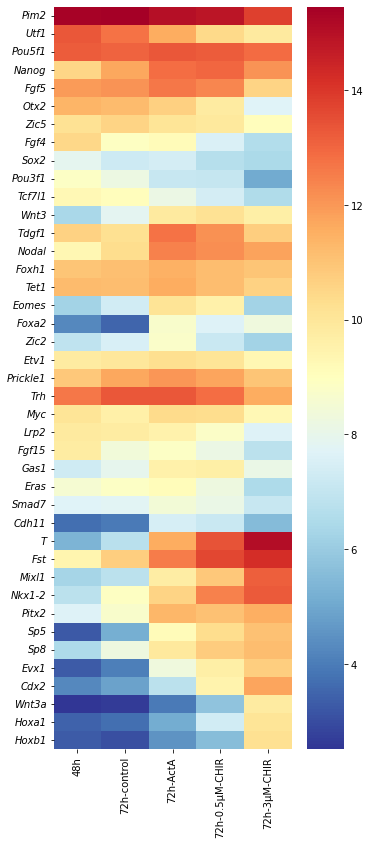

In [68]:
# retain samples of interest
d_s = df1.loc[[i in retain for i in df1.index],markers_act_chir_72h]
d_s_mean = d_s.groupby([i[:-2] for i in d_s.index]).mean()

fig,ax=plt.subplots(1,1, figsize=(len(retain)/3,len(markers_act_chir_72h)/3))

sns.heatmap(
    d_s_mean.loc[['48h','72h-3μMc-DMSO','72h-high-ActA',
                  '72h-0.5μM-CHIR','72h-3μM-CHIR']].transpose(),
    cmap="RdYlBu_r",
    ax=ax
)
ax.set_xticklabels(['48h','72h-control','72h-ActA','72h-0.5μM-CHIR','72h-3μM-CHIR'],color='black')
ax.tick_params('y', labelrotation=0, color='black')
ax.set_yticklabels(ax.get_yticklabels(), style='italic')

plt.savefig(f"results/bulk_analysis_heatmap_act_vs_chir_72h.{save_format}",bbox_inches="tight",transparent=True)

# 96h

In [69]:
retain=[
        '96h-high-ActA_1','96h-high-ActA_2','96h-high-ActA_3',
        '96h-3μM-CHIR_1','96h-3μM-CHIR_2','96h-3μM-CHIR_3']

In [70]:
markers_act_chir_96h=pd.read_excel("marker_genes.xlsx",sheet_name='chir_acta_96h',header=None).values[:,0]

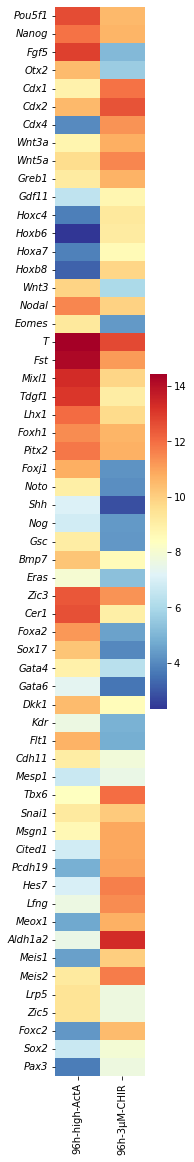

In [71]:
# retain samples of interest
d_s = df1.loc[[i in retain for i in df1.index],markers_act_chir_96h]
d_s_mean = d_s.groupby([i[:-2] for i in d_s.index]).mean()

fig,ax=plt.subplots(1,1, figsize=(len(retain)/3,len(markers_act_chir_96h)/3))

sns.heatmap(
    d_s_mean.loc[['96h-high-ActA','96h-3μM-CHIR']].transpose(),
    cmap="RdYlBu_r",
    ax=ax
)
ax.set_xticklabels(['96h-high-ActA','96h-3μM-CHIR'],color='black')
ax.tick_params('y', labelrotation=0, color='black')
ax.set_yticklabels(ax.get_yticklabels(), style='italic')

plt.savefig(f"results/bulk_analysis_heatmap_act_vs_chir_96h.{save_format}",bbox_inches="tight",transparent=True)

# 120h

In [72]:
retain = [
        '120h-high-ActA_1','120h-high-ActA_2','120h-high-ActA_3',
        '120h-3μM-CHIR_1','120h-3μM-CHIR_2','120h-3μM-CHIR_3']

In [73]:
markers_act_chir_120h=pd.read_excel("marker_genes.xlsx",sheet_name='chir_acta_120h',header=None).values[:,0]

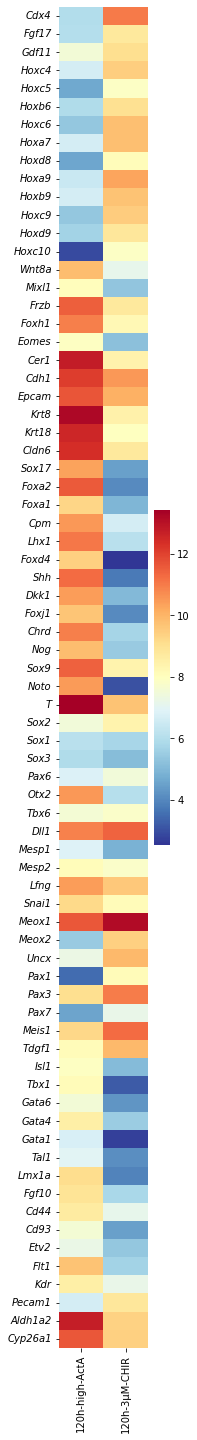

In [74]:
# retain samples of interest
d_s = df1.loc[[i in retain for i in df1.index],markers_act_chir_120h]
d_s_mean = d_s.groupby([i[:-2] for i in d_s.index]).mean()

fig,ax=plt.subplots(1,1, figsize=(len(retain)/3,len(markers_act_chir_120h)/3))

sns.heatmap(
    d_s_mean.loc[['120h-high-ActA','120h-3μM-CHIR']].transpose(),
    cmap="RdYlBu_r",
    ax=ax
)
ax.set_xticklabels(['120h-high-ActA','120h-3μM-CHIR'],color='black')
ax.tick_params('y', labelrotation=0, color='black')
ax.set_yticklabels(ax.get_yticklabels(), style='italic')

plt.savefig(f"results/bulk_analysis_heatmap_act_vs_chir_120h.{save_format}",bbox_inches="tight",transparent=True)